# Fine-Tuning Llama 3.1 8B for Summarization

This notebook fine-tunes the Llama 3.1 8B model for summarization using the `philschmid/guanaco-sharegpt-style` dataset. It includes dataset downloading, preprocessing, fine-tuning with QLoRA and Unsloth, and evaluation with ROUGE-L scores and loss plotting.

## Setup
- **Environment**: Google Colab with T4 GPU (16GB VRAM).
- **Libraries**: Unsloth for efficient fine-tuning, Hugging Face Transformers, Datasets, and Evaluate for metrics.
- **Dataset**: `philschmid/guanaco-sharegpt-style` (ShareGPT format).
- **Output**: Fine-tuned model, ROUGE-L scores, and loss graph.

Let’s get started!

In [ ]:
# %%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install transformers==4.51.3
    !pip install --no-deps unsloth
# !pip install datasets evaluate rouge_score transformers torch
# !pip install trl peft bitsandbytes
import torch



## 1. Install Dependencies

Install required libraries, including Unsloth for efficient fine-tuning and other dependencies for dataset handling and evaluation.

## 2. Load and Preprocess Dataset

We load the `philschmid/guanaco-sharegpt-style` dataset and preprocess it to extract summarization tasks. The dataset is in ShareGPT format, so we’ll filter for summarization instructions and format them for training.

In [ ]:
from datasets import load_dataset

# Load dataset
dataset = load_dataset("philschmid/guanaco-sharegpt-style", split="train")

# Define formatting function for summarization
def formatting_prompts_func(examples):
    texts = []
    for conv in examples["conversations"]:
        # Filter for summarization tasks
        for message in conv:
            if message["from"] == "human" and "summarize" in message["value"].lower():
                human_text = message["value"]
                # Find the corresponding assistant response
                assistant_idx = conv.index(message) + 1
                if assistant_idx < len(conv) and conv[assistant_idx]["from"] == "gpt":
                    assistant_text = conv[assistant_idx]["value"]
                    # Format as instruction template
                    text = f"<|start_header_id|>user<|end_header_id>\n\n{human_text}\n\n<|start_header_id|>assistant<|end_header_id>\n\n{assistant_text}"
                    texts.append(text)
                break
    return {"text": texts}

# Apply formatting and filter out empty results
dataset = dataset.map(formatting_prompts_func, batched=True, remove_columns=["conversations"])
dataset = dataset.filter(lambda x: len(x["text"]) > 0)

# Split dataset into train and test (90% train, 10% test)
dataset = dataset.train_test_split(test_size=0.1)
train_dataset = dataset["train"]
test_dataset = dataset["test"]

print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Training samples: 19, Test samples: 3


## 3. Load Model and Tokenizer

Load the Llama 3.1 8B model with 4-bit quantization using Unsloth for memory efficiency. We also configure the tokenizer with the Llama 3.1 chat template.

In [ ]:
from unsloth import FastLanguageModel
from transformers import AutoTokenizer
from unsloth.chat_templates import get_chat_template

# Model and tokenizer configuration
model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit"
max_seq_length = 2048

# Load model with 4-bit quantization
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=max_seq_length,
    dtype= None,
    load_in_4bit=True,
)

# Apply Llama 3.1 chat template
tokenizer = get_chat_template(
    tokenizer=tokenizer,
    chat_template="llama-3.1"
)

print("Model and tokenizer loaded.")

==((====))==  Unsloth 2025.5.9: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Model and tokenizer loaded.


## 4. Configure QLoRA and Training Arguments

Use QLoRA for parameter-efficient fine-tuning and set up training arguments optimized for Colab’s T4 GPU.

In [ ]:
from peft import LoraConfig, TaskType
from transformers import TrainingArguments
from trl import SFTTrainer
from unsloth import is_bfloat16_supported

# QLoRA configuration
# peft_config = LoraConfig(
#     r=16,
#     lora_alpha=32,
#     target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
#     lora_dropout=0.05,
#     bias="none",
#     task_type= TaskType.CAUSAL_LM,
# )
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    use_gradient_checkpointing=True,
    random_state=42,
    use_rslora=False,
    loftq_config= None,
)


# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    warmup_steps=5,
    max_steps=100,  # Limit for demo; increase for full training
    learning_rate=2e-4,
    fp16=not is_bfloat16_supported(),
    bf16=is_bfloat16_supported(),
    logging_steps=1,
    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    report_to="none",
    save_strategy="steps",
    save_steps=50
)

print("QLoRA and training arguments configured.")

Unsloth 2025.5.9 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


QLoRA and training arguments configured.


## 5. Evaluate Model Before Fine-Tuning

Generate summaries on the test dataset using the base model and compute ROUGE-L scores for comparison.

In [ ]:
from evaluate import load
import numpy as np

# Load ROUGE metric

rouge = load("rouge")

def evaluate_model(model, tokenizer, dataset, max_samples=50):
    predictions = []
    references = []
    model.eval()
    for i, example in enumerate(dataset):
        if i >= max_samples:
            break
        # Extract input and reference summary
        text = example["text"]
        # The input text should end just before the assistant's response
        input_text = text.split("<|start_header_id|>assistant<|end_header_id>")[0]
        # The reference should be the assistant's response part
        try:
            reference = text.split("<|start_header_id|>assistant<|end_header_id>")[1].strip()
        except IndexError:
             # If the expected split is not found in the reference text, skip this example
            print(f"Warning: Could not find assistant response separator in example {i}. Skipping.")
            continue

        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=max_seq_length).to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=200, do_sample=True, temperature=0.7)
        decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Split the decoded output to get the generated response
        output_parts = decoded_output.split("<|start_header_id|>assistant<|end_header_id>")

        if len(output_parts) > 1:
            prediction = output_parts[1].strip()
        else:
            prediction = decoded_output.strip()
            print(f"Warning: Separator not found in model output for example {i}. Using full output as prediction.")


        predictions.append(prediction)
        references.append(reference)

    # Compute ROUGE-L
    results = rouge.compute(predictions=predictions, references=references)
    return results, predictions, references

# Evaluate base model
base_rouge, base_predictions, base_references = evaluate_model(model, tokenizer, test_dataset)
print("Base Model ROUGE-L:", base_rouge["rougeL"])

Base Model ROUGE-L: 0.23139853463823382


## 6. Fine-Tune the Model

Use SFTTrainer with Unsloth to fine-tune the model, computing loss only on the assistant’s responses.

In [ ]:
from unsloth.chat_templates import train_on_responses_only
from transformers import DataCollatorForSeq2Seq
# Initialize trainer

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    args=training_args,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer)
)

# Train only on assistant responses
# trainer = train_on_responses_only(
#     trainer,
#     instruction_part="<|start_header_id|>user<|end_header_id>",
#     response_part="<|start_header_id|>assistant<|end_header_id>"
# )

# Train and save losses
training_stats = trainer.train()
losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]

# Save the fine-tuned model
model.save_pretrained("llama-3.1-8b-summarization")
tokenizer.save_pretrained("llama-3.1-8b-summarization")

print("Fine-tuning complete.")

Unsloth: Tokenizing ["text"]:   0%|          | 0/19 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 19 | Num Epochs = 50 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.680400
2,1.908100
3,1.359400
4,2.118400
5,1.307600
6,1.319700
7,1.352100
8,1.087500
9,1.698700
10,1.088000


Fine-tuning complete.


## 7. Evaluate Model After Fine-Tuning

Evaluate the fine-tuned model on the test dataset and compute ROUGE-L scores.

In [ ]:
# Reload fine-tuned model for evaluation
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="llama-3.1-8b-summarization",
    max_seq_length=max_seq_length,
    dtype=torch.float16,
    load_in_4bit=True,
    device_map="auto"
)


==((====))==  Unsloth 2025.5.9: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Fine-Tuned Model ROUGE-L: 0.24118600576527147


## 8. Plot ROUGE-L and Loss

Visualize the ROUGE-L scores before and after fine-tuning and the training loss curve.

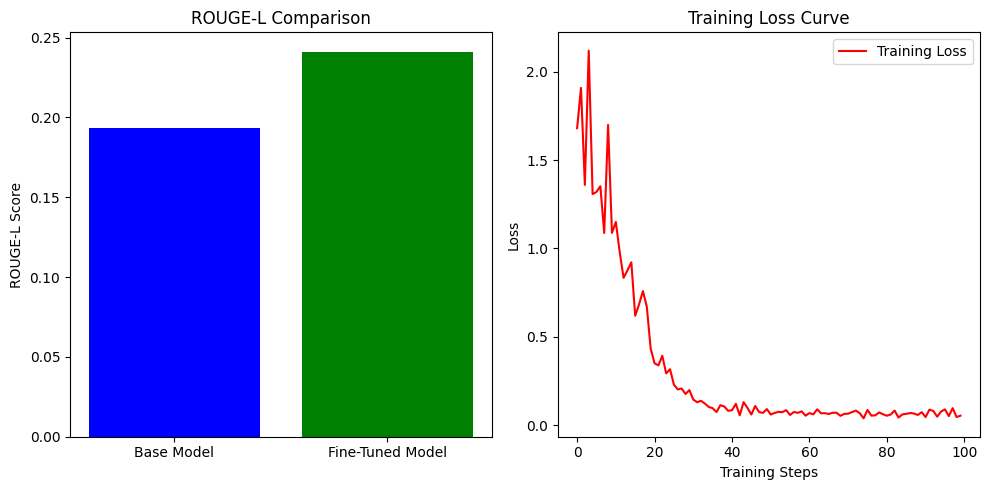

In [ ]:
import matplotlib.pyplot as plt

# Plot ROUGE-L comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(["Base Model", "Fine-Tuned Model"], [base_rouge["rougeL"], ft_rouge["rougeL"]], color=["blue", "green"])
plt.title("ROUGE-L Comparison")
plt.ylabel("ROUGE-L Score")

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(losses, label="Training Loss", color="red")
plt.title("Training Loss Curve")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("rouge_loss_plot.png")
plt.show()

## 9. Conclusion

The fine-tuned Llama 3.1 8B model should show improved ROUGE-L scores compared to the base model for summarization tasks. The loss curve indicates training stability. To improve performance further, consider:
- Increasing `max_steps` or `num_train_epochs`.
- Using a larger or more domain-specific summarization dataset.
- Adjusting LoRA parameters (e.g., `r`, `lora_alpha`).

The fine-tuned model is saved in `./llama-3.1-8b-summarization` and can be used for inference or deployment.